In [2]:
import numpy as np
import os, glob

import matplotlib.pyplot as plt

from PIL import Image

from scipy.stats import ttest_ind

# ..........torch imports............
import torch
import torchvision

from torch.utils.data import IterableDataset, DataLoader
from torchvision import transforms
import gc


from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Imported the necessary libraries

For this experiment, we will be using GoogleNet model pre-trained on ImageNet data-set.

In [3]:
import torchvision.models as models

model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
model.eval()

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 119MB/s] 


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

These are the layers on which we are going to perform our experiment

In [4]:
layers=['inception4c', 'inception4d', 'inception4e']

Displaying some random images from the data set of concepts

In [5]:
import random

def display_random_images(concept_name, concept_path, num_images=5):
    """
    Display the concept name and a specified number of random images from the concept structure.

    Args:
        concept_structure (dict): A dictionary containing the concept ID, name, and path.
        num_images (int): Number of random images to display.
    """
#     concept_name = concept_structure['name']
#     concept_path = concept_structure['path']

    if not os.path.exists(concept_path):
        raise ValueError(f"Provided path does not exist: {concept_path}")

    # List all image files in the concept path
    image_files = [os.path.join(concept_path, f) for f in os.listdir(concept_path) if os.path.isfile(os.path.join(concept_path, f))]

    if len(image_files) == 0:
        raise ValueError("No images found in the provided concept path.")

    # Select random images
    random_images = random.sample(image_files, min(num_images, len(image_files)))

    # Set up the plot
    fig, axs = plt.subplots(1, num_images + 1, figsize=(20, 5))

    # Display the concept name on the first subplot
    axs[0].text(0.5, 0.5, concept_name, fontsize=20, va='center', ha='center')
    axs[0].axis('off')

    # Display images
    for i, image_file in enumerate(random_images):
        img = Image.open(image_file)
        axs[i + 1].imshow(img)
        axs[i + 1].axis('off')
        axs[i + 1].set_title(f"Image {i + 1}")

    plt.show()

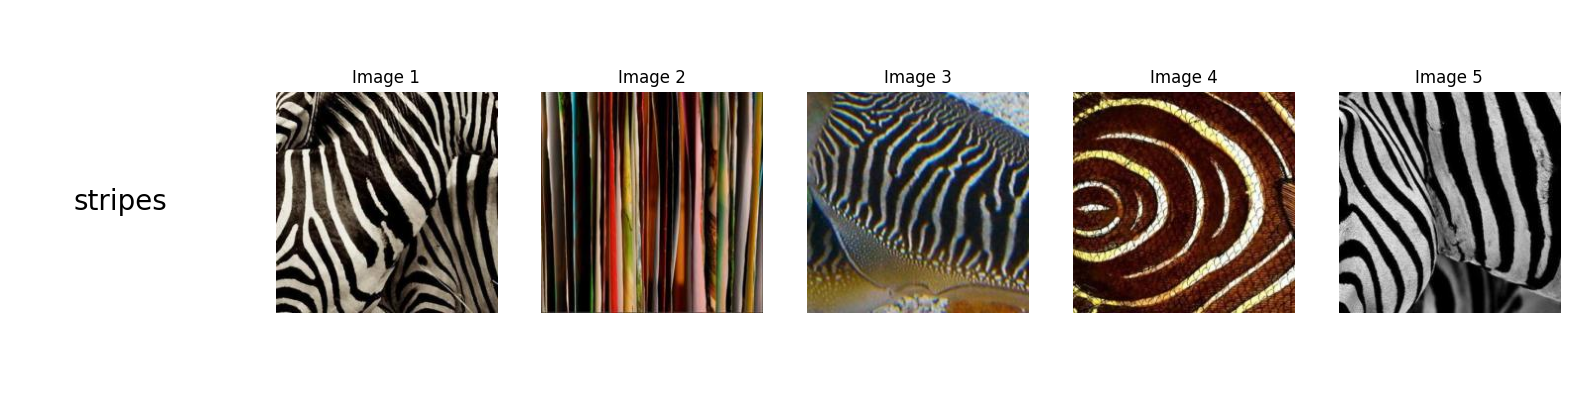

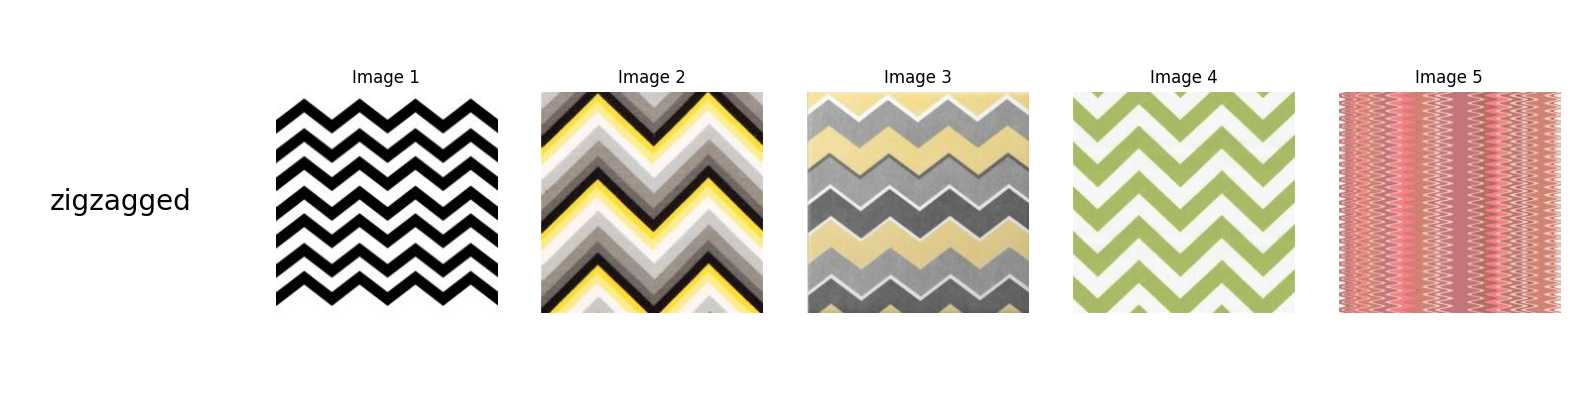

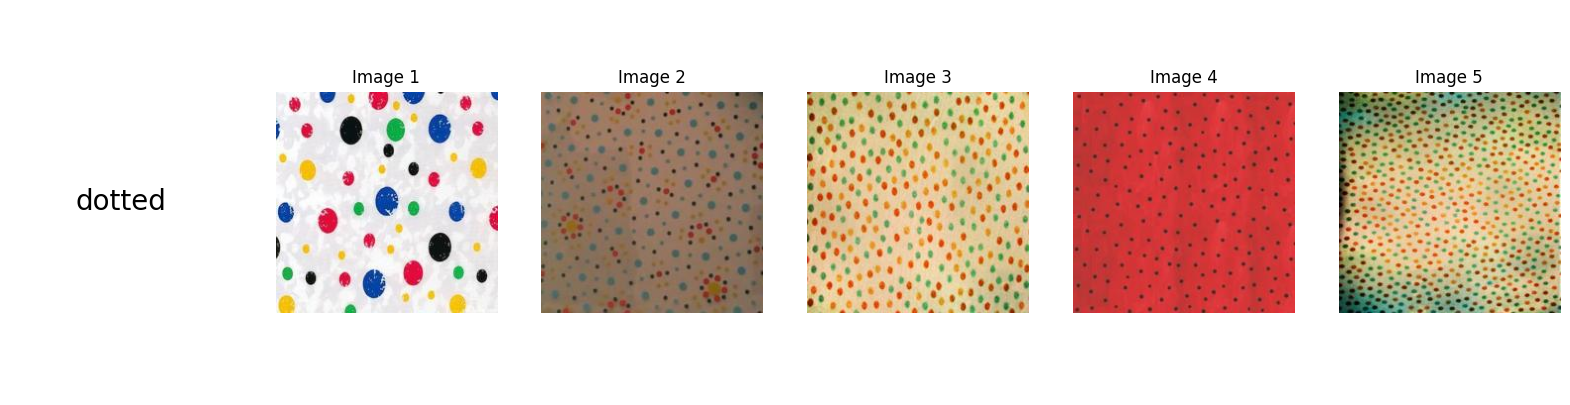

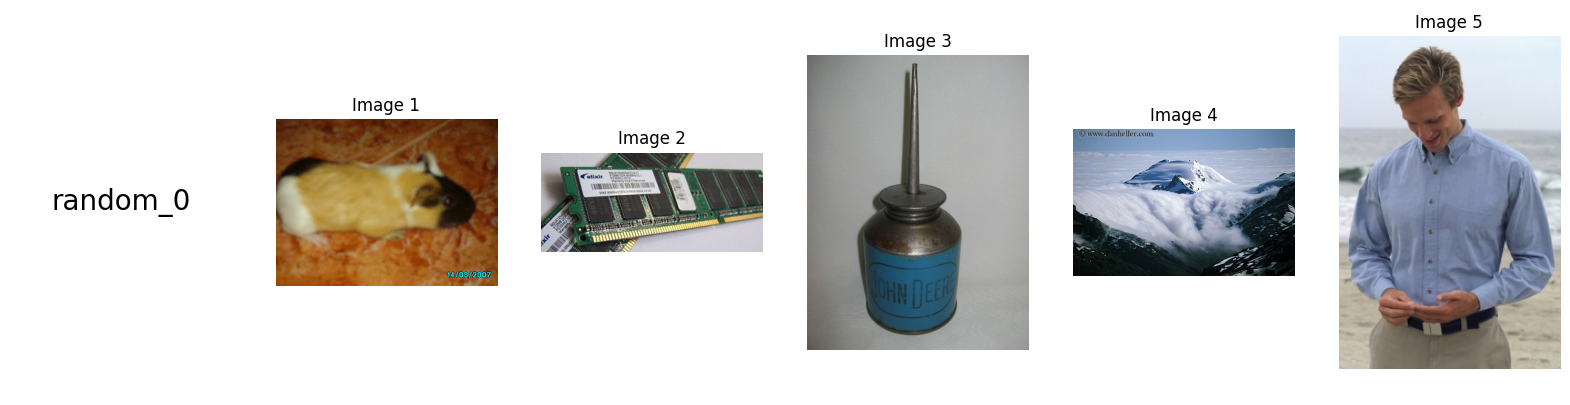

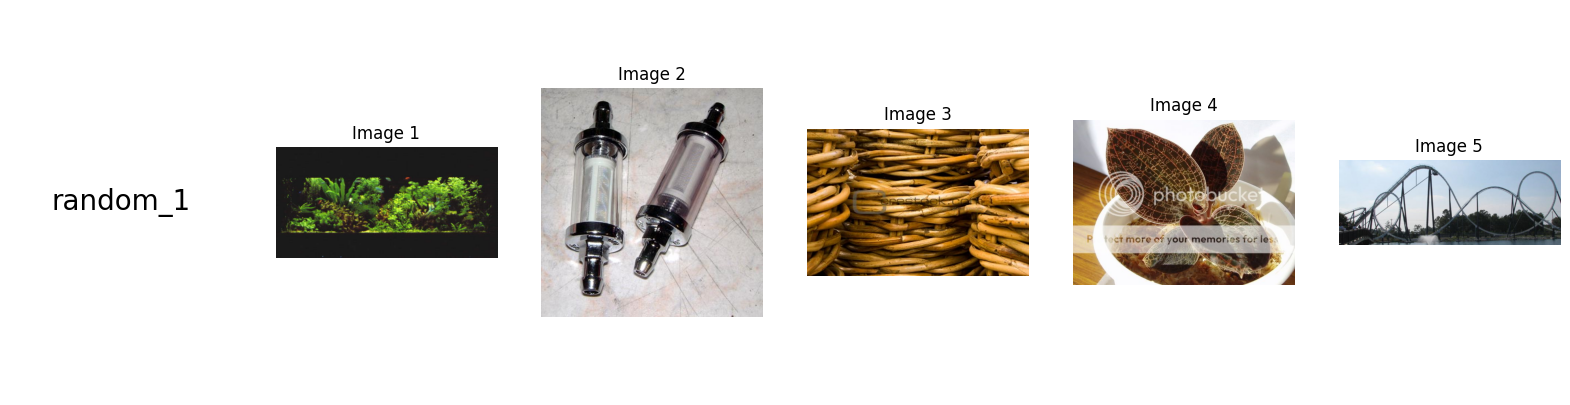

In [6]:
display_random_images("stripes", "/kaggle/input/all-the-images/data/tcav/image/concepts/striped")
display_random_images("zigzagged", "/kaggle/input/all-the-images/data/tcav/image/concepts/zigzagged")
display_random_images("dotted", "/kaggle/input/all-the-images/data/tcav/image/concepts/dotted")

display_random_images("random_0", "/kaggle/input/all-the-images/data/tcav/image/concepts/random_0")
display_random_images("random_1", "/kaggle/input/all-the-images/data/tcav/image/concepts/random_1")

Basic Transformation functions to feed the data in the model

In [7]:
def transform(img):
    return transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )(img)


def load_image_tensors(class_name, root_path, transform=True):
    path = os.path.join(root_path, class_name)
    filenames = glob.glob(path + '/*.jpg')

    tensors = []
    for filename in filenames:
        img = Image.open(filename).convert('RGB')
        tensors.append(transform(img) if transform else img)

    return tensors

Displaying random zebra images

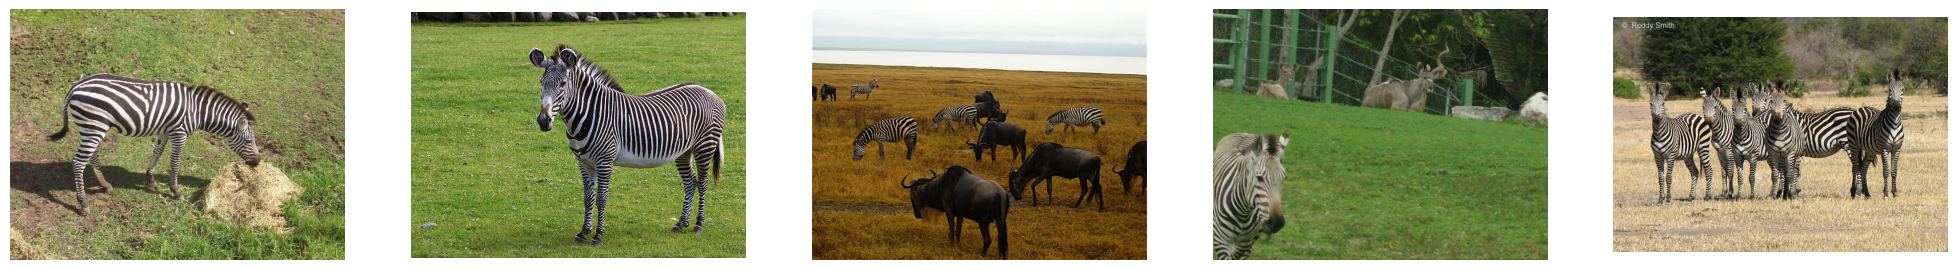

In [8]:
# Load sample images from folder
zebra_imgs = load_image_tensors('zebra',"/kaggle/input/all-the-images/data/tcav/image/imagenet",transform=False)

fig, axs = plt.subplots(1, 5, figsize = (25, 5))
axs[0].imshow(zebra_imgs[25])
axs[1].imshow(zebra_imgs[26])
axs[2].imshow(zebra_imgs[19])
axs[3].imshow(zebra_imgs[16])
axs[4].imshow(zebra_imgs[15])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')

plt.show()

In [9]:
# Load sample images from folder
zebra_tensors = torch.stack([transform(img) for img in zebra_imgs])

Now, here the experiment starts.<br>
We are actually calculating activations of each concept, from the specified layer one by one.<br>
We are starting with the stripped concept, for positive examples, we take stripped images while for negative examples, we take random_0 and random_1 images.

In [10]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Ensure image is RGB (3 channels)
    preprocess = transforms.Compose([
        transforms.Resize(256),  # Resize to 256x256
        transforms.CenterCrop(224),  # Center crop to 224x224
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    image_tensor = preprocess(image)
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    return image_tensor

In [14]:
# Function to extract activations from a specified layer
def get_activations(model, image_tensor, layer_name):
    activations = None
    # Register a hook to capture activations from the desired layer
    def hook(module, input, output):
        nonlocal activations
        activations = output
    
    # Find the specified layer in the model
    target_layer = None
    for name, module in model.named_modules():
        if name == layer_name:
            target_layer = module
            break
    
    if target_layer is None:
        raise ValueError(f"Layer '{layer_name}' not found in the model.")
    
    # Register the hook
    hook_handle = target_layer.register_forward_hook(hook)
    
    # Forward pass to compute activations
    with torch.no_grad():
        model.eval()
        model(image_tensor)
    
    # Remove the hook after obtaining activations
    hook_handle.remove()
    
    return activations

These are the activations of the stripped concept.

In [151]:
stripped_path = '/kaggle/input/all-the-images/data/tcav/image/concepts/striped'

# List all files in the folder
files = os.listdir(stripped_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

stripped_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(stripped_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[0])
    stripped_activations.append(helper)

Activations of random_0.

In [152]:
random0_path = '/kaggle/input/all-the-images/data/tcav/image/concepts/random_0'

# List all files in the folder
files = os.listdir(random0_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

random0_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(random0_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[0])
    random0_activations.append(helper)

Activations of random_1

In [153]:
random1_path = '/kaggle/input/all-the-images/data/tcav/image/concepts/random_1'

# List all files in the folder
files = os.listdir(random1_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

random1_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(random1_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[0])
    random1_activations.append(helper)

In [154]:
stripes_activations_np = np.array(stripped_activations)
random_activations_np = np.array(random0_activations)
random1_activations_np = np.array(random1_activations)

Now, we are taking a linear classifier, to give the activations of a concept(stripes in this case) and further learn the CAV from it.<br>
CAV is nothing but the vector normal to the decision boundary in the direction of the positive examples.

In [155]:
X = np.concatenate((stripes_activations_np, random_activations_np, random1_activations_np), axis=0)
y = np.concatenate((np.ones(stripes_activations_np.shape[0]), np.zeros(random1_activations_np.shape[0]), np.zeros(random_activations_np.shape[0])))

In [174]:
X = X.reshape(X.shape[0], -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [175]:
classifier = SGDClassifier(random_state=42, max_iter=1000000000, tol=1e-3)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classifier accuracy: {accuracy * 100:.2f}%")

Classifier accuracy: 100.00%


We calculate the CAV here.

In [176]:
cav = classifier.coef_.flatten()

cav_normalized = cav / np.linalg.norm(cav)

In [177]:
activations = []
gradients = []

def hook_fn(module, input, output):
    activations.append(output)
    output.register_hook(lambda grad: gradients.append(grad))

def get_activations_and_gradients(model, input_tensor, target_class, layer_name):
    # Register hook to the specified layer
    layer = dict([*model.named_modules()])[layer_name]
    hook = layer.register_forward_hook(hook_fn)

    input_tensor.requires_grad = True
    model_output = model(input_tensor)
    model_output[:, target_class].backward()

    hook.remove()

    # Get the last recorded activations and gradients
    act = activations[-1].detach().numpy()
    grad = gradients[-1].detach().numpy()

    # Clear the lists for the next iteration
    activations.clear()
    gradients.clear()

    return act, grad

def compute_directional_derivative(gradients, cav):
    directional_derivatives = []
    for grad in gradients:
        # Debugging information
        print(f"Gradients shape: {grad.shape}, CAV shape: {cav.shape}")

        # Ensure both gradients and CAV are flattened for the dot product
        grad_flat = grad.flatten()
        cav_flat = cav.flatten()

        if grad_flat.shape != cav_flat.shape:
            raise ValueError(f"Shape mismatch: Gradients shape {grad_flat.shape} and CAV shape {cav_flat.shape} are not aligned.")

        directional_derivatives.append(np.dot(grad_flat, cav_flat))
    return np.array(directional_derivatives)

def compute_tcav_score(directional_derivatives):
    directional_derivatives = np.array(directional_derivatives)
    positive_count = np.sum(directional_derivatives > 0)
    tcav_score = positive_count / len(directional_derivatives)
    return tcav_score

def process_images_in_folder(folder_path, model, cav, target_class, layer_name):
    directional_derivatives = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # You can add other image formats if needed
            image_path = os.path.join(folder_path, filename)
            input_tensor = load_image(image_path)
            activations, gradients = get_activations_and_gradients(model, input_tensor, target_class, layer_name)
            derivatives = compute_directional_derivative(gradients, cav)
            directional_derivatives.extend(derivatives)

    tcav_score = compute_tcav_score(directional_derivatives)
    return tcav_score

Now, we calculate the TCAV score, by using the CAV and the concept senstivity and aggregate them to make TCAV score.<br>
While, one direction gives us the TCAV score for positive examples i.e. the concept shown by the vector and the other one gives us the TCAV score for negative examples.

In [178]:
folder_path = '/kaggle/input/all-the-images/data/tcav/image/imagenet/zebra'
tcav_score = process_images_in_folder(folder_path, model, cav_normalized, 340, layers[0])
print(f"TCAV Score: {tcav_score}")

Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (10

In [179]:
folder_path = '/kaggle/input/all-the-images/data/tcav/image/imagenet/zebra'
tcav_score = process_images_in_folder(folder_path, model, -1 * cav_normalized, 340, layers[0])
print(f"TCAV Score: {tcav_score}")

Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (10

Now, we repeat the same process for layers[1] and layers[2].

In [116]:
# List all files in the folder
files = os.listdir(stripped_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

stripped_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(stripped_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[1])
    stripped_activations.append(helper)

In [117]:
# List all files in the folder
files = os.listdir(random0_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

random0_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(random0_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[1])
    random0_activations.append(helper)

In [118]:
# List all files in the folder
files = os.listdir(random1_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

random1_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(random1_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[1])
    random1_activations.append(helper)

In [119]:
stripes_activations_np = np.array(stripped_activations)
random_activations_np = np.array(random0_activations)
random1_activations_np = np.array(random1_activations)

In [120]:
X = np.concatenate((stripes_activations_np, random_activations_np, random1_activations_np), axis=0)
y = np.concatenate((np.ones(stripes_activations_np.shape[0]), np.zeros(random1_activations_np.shape[0]), np.zeros(random_activations_np.shape[0])))

In [136]:
X = X.reshape(X.shape[0], -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [137]:
classifier = SGDClassifier(random_state=42, max_iter=1000000000, tol=1e-3)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classifier accuracy: {accuracy * 100:.2f}%")

Classifier accuracy: 100.00%


In [138]:
cav = classifier.coef_.flatten()

cav_normalized = cav / np.linalg.norm(cav)

In [139]:
folder_path = '/kaggle/input/all-the-images/data/tcav/image/imagenet/zebra'
tcav_score = process_images_in_folder(folder_path, model, cav_normalized, 340, layers[1])
print(f"TCAV Score: {tcav_score}")

Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (10

In [140]:
folder_path = '/kaggle/input/all-the-images/data/tcav/image/imagenet/zebra'
tcav_score = process_images_in_folder(folder_path, model, -1* cav_normalized, 340, layers[1])
print(f"TCAV Score: {tcav_score}")

Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (10

In [141]:
# List all files in the folder
files = os.listdir(stripped_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

stripped_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(stripped_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[2])
    stripped_activations.append(helper)

In [142]:
# List all files in the folder
files = os.listdir(random0_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

random0_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(random0_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[2])
    random0_activations.append(helper)

In [143]:
# List all files in the folder
files = os.listdir(random1_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

random1_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(random1_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[2])
    random1_activations.append(helper)

In [144]:
stripes_activations_np = np.array(stripped_activations)
random_activations_np = np.array(random0_activations)
random1_activations_np = np.array(random1_activations)

In [145]:
X = np.concatenate((stripes_activations_np, random_activations_np, random1_activations_np), axis=0)
y = np.concatenate((np.ones(stripes_activations_np.shape[0]), np.zeros(random1_activations_np.shape[0]), np.zeros(random_activations_np.shape[0])))

In [146]:
X = X.reshape(X.shape[0], -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [147]:
classifier = SGDClassifier(random_state=42, max_iter=1000000000, tol=1e-3)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classifier accuracy: {accuracy * 100:.2f}%")

Classifier accuracy: 100.00%


In [148]:
cav = classifier.coef_.flatten()

cav_normalized = cav / np.linalg.norm(cav)

In [149]:
folder_path = '/kaggle/input/all-the-images/data/tcav/image/imagenet/zebra'
tcav_score = process_images_in_folder(folder_path, model, -1* cav_normalized, 340, layers[2])
print(f"TCAV Score: {tcav_score}")

Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (16

In [150]:
folder_path = '/kaggle/input/all-the-images/data/tcav/image/imagenet/zebra'
tcav_score = process_images_in_folder(folder_path, model, cav_normalized, 340, layers[2])
print(f"TCAV Score: {tcav_score}")

Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (16

Now, displaying the final result in the form of a bar chart.

In [181]:
normalized_scores = {
    layers[0]: {'stripped': 0.7714285714285715, 'random': 1-0.7714285714285715},
    layers[1]: {'stripped': 0.7142857142857143, 'random': 1-0.7142857142857143},
    layers[2]: {'stripped': 0.8, 'random': 0.2}
}

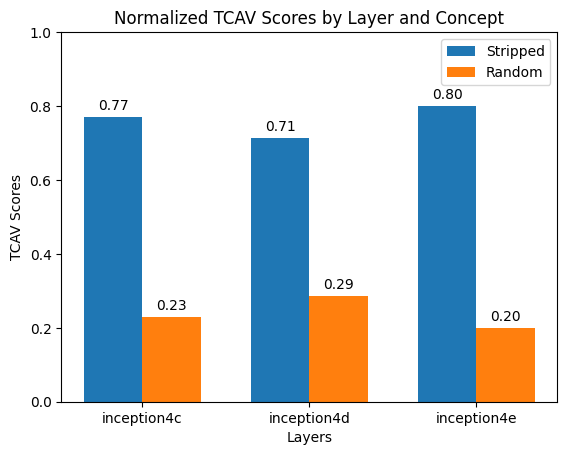

In [213]:
layers = list(normalized_scores.keys())
stripped_scores = [normalized_scores[layer]['stripped'] for layer in layers]
random_scores = [normalized_scores[layer]['random'] for layer in layers]

# Bar chart settings
x = np.arange(len(layers))  # the label locations
width = 0.35  # the width of the bars

# Create subplots
fig, ax = plt.subplots()

# Plot bars
bars1 = ax.bar(x - width/2, stripped_scores, width, label='Stripped')
bars2 = ax.bar(x + width/2, random_scores, width, label='Random')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Layers')
ax.set_ylabel('TCAV Scores')
ax.set_title('Normalized TCAV Scores by Layer and Concept')
ax.set_xticks(x)
ax.set_xticklabels(layers)
ax.set_ylim(0, 1)
ax.legend()

# Attach a text label above each bar in *bars1* and *bars2*, displaying its height.
def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('%.2f' % height,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

# Display the plot
plt.show()

Now, we repeat the same process for the zigzagged concept and then we will further do this for dotted concept and calculate their TCAV scores.

In [189]:
zigzagged_path = "/kaggle/input/all-the-images/data/tcav/image/concepts/zigzagged"

# List all files in the folder
files = os.listdir(zigzagged_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

zigzagged_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(zigzagged_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[0])
    zigzagged_activations.append(helper)

In [187]:
random0_path = '/kaggle/input/all-the-images/data/tcav/image/concepts/random_0'

# List all files in the folder
files = os.listdir(random0_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

random0_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(random0_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[0])
    random0_activations.append(helper)

In [188]:
random1_path = '/kaggle/input/all-the-images/data/tcav/image/concepts/random_1'

# List all files in the folder
files = os.listdir(random1_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

random1_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(random1_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[0])
    random1_activations.append(helper)

In [190]:
zigzagged_activations_np = np.array(zigzagged_activations)
random_activations_np = np.array(random0_activations)
random1_activations_np = np.array(random1_activations)

In [191]:
X = np.concatenate((zigzagged_activations_np, random_activations_np, random1_activations_np), axis=0)
y = np.concatenate((np.ones(zigzagged_activations_np.shape[0]), np.zeros(random1_activations_np.shape[0]), np.zeros(random_activations_np.shape[0])))

In [209]:
X = X.reshape(X.shape[0], -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [210]:
classifier = SGDClassifier(random_state=42, max_iter=1000000000, tol=1e-3)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classifier accuracy: {accuracy * 100:.2f}%")

Classifier accuracy: 100.00%


In [211]:
cav = classifier.coef_.flatten()

cav_normalized = cav / np.linalg.norm(cav)

In [212]:
folder_path = '/kaggle/input/all-the-images/data/tcav/image/imagenet/zebra'
tcav_score = process_images_in_folder(folder_path, model, cav_normalized, 340, layers[0])
print(f"TCAV Score: {tcav_score}")

Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (10

In [214]:
zigzagged_path = "/kaggle/input/all-the-images/data/tcav/image/concepts/zigzagged"

# List all files in the folder
files = os.listdir(zigzagged_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

zigzagged_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(zigzagged_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[1])
    zigzagged_activations.append(helper)

In [215]:
random0_path = '/kaggle/input/all-the-images/data/tcav/image/concepts/random_0'

# List all files in the folder
files = os.listdir(random0_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

random0_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(random0_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[1])
    random0_activations.append(helper)

In [216]:
random1_path = '/kaggle/input/all-the-images/data/tcav/image/concepts/random_1'

# List all files in the folder
files = os.listdir(random1_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

random1_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(random1_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[1])
    random1_activations.append(helper)

In [217]:
zigzagged_activations_np = np.array(zigzagged_activations)
random_activations_np = np.array(random0_activations)
random1_activations_np = np.array(random1_activations)

In [218]:
X = np.concatenate((zigzagged_activations_np, random_activations_np, random1_activations_np), axis=0)
y = np.concatenate((np.ones(zigzagged_activations_np.shape[0]), np.zeros(random1_activations_np.shape[0]), np.zeros(random_activations_np.shape[0])))

In [228]:
X = X.reshape(X.shape[0], -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [229]:
classifier = SGDClassifier(random_state=42, max_iter=1000000000, tol=1e-3)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classifier accuracy: {accuracy * 100:.2f}%")

Classifier accuracy: 98.33%


In [230]:
cav = classifier.coef_.flatten()

cav_normalized = cav / np.linalg.norm(cav)

In [231]:
folder_path = '/kaggle/input/all-the-images/data/tcav/image/imagenet/zebra'
tcav_score = process_images_in_folder(folder_path, model, cav_normalized, 340, layers[1])
print(f"TCAV Score: {tcav_score}")

Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (10

In [233]:
zigzagged_path = "/kaggle/input/all-the-images/data/tcav/image/concepts/zigzagged"

# List all files in the folder
files = os.listdir(zigzagged_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

zigzagged_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(zigzagged_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[2])
    zigzagged_activations.append(helper)

In [234]:
random0_path = '/kaggle/input/all-the-images/data/tcav/image/concepts/random_0'

# List all files in the folder
files = os.listdir(random0_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

random0_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(random0_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[2])
    random0_activations.append(helper)

In [235]:
random1_path = '/kaggle/input/all-the-images/data/tcav/image/concepts/random_1'

# List all files in the folder
files = os.listdir(random1_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

random1_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(random1_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[2])
    random1_activations.append(helper)

In [236]:
zigzagged_activations_np = np.array(zigzagged_activations)
random_activations_np = np.array(random0_activations)
random1_activations_np = np.array(random1_activations)

In [245]:
X = np.concatenate((zigzagged_activations_np, random_activations_np, random1_activations_np), axis=0)
y = np.concatenate((np.ones(zigzagged_activations_np.shape[0]), np.zeros(random1_activations_np.shape[0]), np.zeros(random_activations_np.shape[0])))

X = X.reshape(X.shape[0], -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [246]:
classifier = SGDClassifier(random_state=42, max_iter=1000000000, tol=1e-3)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classifier accuracy: {accuracy * 100:.2f}%")

Classifier accuracy: 100.00%


In [247]:
cav = classifier.coef_.flatten()

cav_normalized = cav / np.linalg.norm(cav)

In [248]:
folder_path = '/kaggle/input/all-the-images/data/tcav/image/imagenet/zebra'
tcav_score = process_images_in_folder(folder_path, model, cav_normalized, 340, layers[2])
print(f"TCAV Score: {tcav_score}")

Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (16

In [251]:
dotted_path = "/kaggle/input/all-the-images/data/tcav/image/concepts/dotted"

# List all files in the folder
files = os.listdir(dotted_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

dotted_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(dotted_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[0])
    dotted_activations.append(helper)

In [253]:
random0_path = '/kaggle/input/all-the-images/data/tcav/image/concepts/random_0'

# List all files in the folder
files = os.listdir(random0_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

random0_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(random0_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[0])
    random0_activations.append(helper)

In [254]:
random1_path = '/kaggle/input/all-the-images/data/tcav/image/concepts/random_1'

# List all files in the folder
files = os.listdir(random1_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

random1_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(random1_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[0])
    random1_activations.append(helper)

In [255]:
dotted_activations_np = np.array(dotted_activations)
random_activations_np = np.array(random0_activations)
random1_activations_np = np.array(random1_activations)

In [269]:
X = np.concatenate((dotted_activations_np, random_activations_np, random1_activations_np), axis=0)
y = np.concatenate((np.ones(dotted_activations_np.shape[0]), np.zeros(random1_activations_np.shape[0]), np.zeros(random_activations_np.shape[0])))

X = X.reshape(X.shape[0], -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [270]:
classifier = SGDClassifier(random_state=42, max_iter=1000000000, tol=1e-3)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classifier accuracy: {accuracy * 100:.2f}%")

Classifier accuracy: 100.00%


In [271]:
cav = classifier.coef_.flatten()

cav_normalized = cav / np.linalg.norm(cav)

In [272]:
folder_path = '/kaggle/input/all-the-images/data/tcav/image/imagenet/zebra'
tcav_score = process_images_in_folder(folder_path, model, cav_normalized, 340, layers[0])
print(f"TCAV Score: {tcav_score}")

Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (100352,)
Gradients shape: (512, 14, 14), CAV shape: (10

In [273]:
dotted_path = "/kaggle/input/all-the-images/data/tcav/image/concepts/dotted"

# List all files in the folder
files = os.listdir(dotted_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

dotted_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(dotted_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[1])
    dotted_activations.append(helper)

In [274]:
random0_path = '/kaggle/input/all-the-images/data/tcav/image/concepts/random_0'

# List all files in the folder
files = os.listdir(random0_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

random0_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(random0_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[1])
    random0_activations.append(helper)

In [275]:
random1_path = '/kaggle/input/all-the-images/data/tcav/image/concepts/random_1'

# List all files in the folder
files = os.listdir(random1_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

random1_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(random1_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[1])
    random1_activations.append(helper)

In [276]:
dotted_activations_np = np.array(dotted_activations)
random_activations_np = np.array(random0_activations)
random1_activations_np = np.array(random1_activations)

In [290]:
X = np.concatenate((dotted_activations_np, random_activations_np, random1_activations_np), axis=0)
y = np.concatenate((np.ones(dotted_activations_np.shape[0]), np.zeros(random1_activations_np.shape[0]), np.zeros(random_activations_np.shape[0])))

X = X.reshape(X.shape[0], -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [291]:
classifier = SGDClassifier(random_state=42, max_iter=1000000000, tol=1e-3)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classifier accuracy: {accuracy * 100:.2f}%")

Classifier accuracy: 100.00%


In [292]:
cav = classifier.coef_.flatten()

cav_normalized = cav / np.linalg.norm(cav)

In [293]:
folder_path = '/kaggle/input/all-the-images/data/tcav/image/imagenet/zebra'
tcav_score = process_images_in_folder(folder_path, model, cav_normalized, 340, layers[1])
print(f"TCAV Score: {tcav_score}")

Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (103488,)
Gradients shape: (528, 14, 14), CAV shape: (10

In [295]:
dotted_path = "/kaggle/input/all-the-images/data/tcav/image/concepts/dotted"

# List all files in the folder
files = os.listdir(dotted_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

dotted_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(dotted_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[2])
    dotted_activations.append(helper)

In [296]:
random0_path = '/kaggle/input/all-the-images/data/tcav/image/concepts/random_0'

# List all files in the folder
files = os.listdir(random0_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

random0_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(random0_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[2])
    random0_activations.append(helper)

In [297]:
random1_path = '/kaggle/input/all-the-images/data/tcav/image/concepts/random_1'

# List all files in the folder
files = os.listdir(random1_path)

# Filter out only the image files (assuming they have common image extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

random1_activations = []
for image_file in image_files:
    # Construct the full path to each image file
    image_path = os.path.join(random1_path, image_file)
    
    img = load_image(image_path)
    helper = get_activations(model, img, layers[2])
    random1_activations.append(helper)

In [306]:
dotted_activations_np = np.array(dotted_activations)
random_activations_np = np.array(random0_activations)
random1_activations_np = np.array(random1_activations)

X = np.concatenate((dotted_activations_np, random_activations_np, random1_activations_np), axis=0)
y = np.concatenate((np.ones(dotted_activations_np.shape[0]), np.zeros(random1_activations_np.shape[0]), np.zeros(random_activations_np.shape[0])))

X = X.reshape(X.shape[0], -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [307]:
classifier = SGDClassifier(random_state=42, max_iter=1000000000, tol=1e-3)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classifier accuracy: {accuracy * 100:.2f}%")

Classifier accuracy: 100.00%


In [308]:
cav = classifier.coef_.flatten()

cav_normalized = cav / np.linalg.norm(cav)

In [309]:
folder_path = '/kaggle/input/all-the-images/data/tcav/image/imagenet/zebra'
tcav_score = process_images_in_folder(folder_path, model, cav_normalized, 340, layers[2])
print(f"TCAV Score: {tcav_score}")

Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (163072,)
Gradients shape: (832, 14, 14), CAV shape: (16

Now, this is the final bar chart, showing how STRIPES, ZIGZAGGED and DOTTED influence the prediction of model for the zebra class.

In [310]:
normalized_scores = {
    layers[0]: {'stripped': 0.7714285714285715, 'zigzagged': 0.45714285714285713, 'dotted' : 0.2857142857142857},
    layers[1]: {'stripped': 0.7142857142857143, 'zigzagged': 0.3142857142857143, 'dotted' : 0.2857142857142857},
    layers[2]: {'stripped': 0.8, 'zigzagged': 0.14285714285714285, 'dotted' : 0.02857142857142857}
}

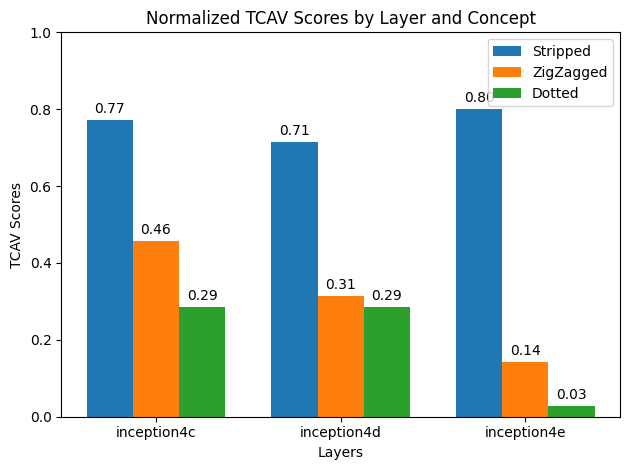

In [312]:
# Example data (replace with your actual data)
layers = list(normalized_scores.keys())
stripped_scores = [normalized_scores[layer]['stripped'] for layer in layers]
zigzagged_scores = [normalized_scores[layer]['zigzagged'] for layer in layers]
dotted_scores = [normalized_scores[layer]['dotted'] for layer in layers]

# Bar chart settings
x = np.arange(len(layers))  # the label locations
width = 0.25  # the width of the bars

# Create subplots
fig, ax = plt.subplots()

# Plot bars
bars1 = ax.bar(x - width, stripped_scores, width, label='Stripped')
bars2 = ax.bar(x, zigzagged_scores, width, label='ZigZagged')
bars3 = ax.bar(x + width, dotted_scores, width, label='Dotted')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Layers')
ax.set_ylabel('TCAV Scores')
ax.set_title('Normalized TCAV Scores by Layer and Concept')
ax.set_xticks(x)
ax.set_xticklabels(layers)
ax.set_ylim(0, 1)
ax.legend()

# Attach a text label above each bar in *bars1*, *bars2*, and *bars3*, displaying its height.
def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('%.2f' % height,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

# Display the plot
plt.tight_layout()
plt.show()


Here is a brief explanation of how TCAV works (Original paper has explained it in a very complex language).<br>
1. Define the human concept on which you want to check the influence of model's predictions on the particular class.
2. Then gather images for that concept, but we need to have some images which don't define the concept, i.e. some negative examples.
3. Further define a model on which you want to apply TCAV and have its data set ready.
4. Now, here is the thing, earlier layers of the model give you very small features like edges, corners, etc. and later layers give you abstract features.
5. Noting the 4th point, decide the layer from which you want to estimate your results(we don't know whether stripes concept will be learned in earlier layers or later layers.)
6. Now, send the images you gathered for the concept, and retrieve activations from the layer.
7. Gsther these activations as these will act as the data set further.
8. Using these activations, train a linear classifier to make a decision boundary to separate positive examples from the negativa ones.
9. Now, there is something called CAV(Concept Activation Vector), this is the vector normal to the decision boundary in the direction of positive examples.
10. Now, we use the concept senstivity and directional derivaties and aggregate them and make the TCAV score(Mathematical terms hai paper mei dekh skte ho).

Higher TCAV score represent higher influence of the concept on the model's predictions and vice-versa.

Now, here is one more thing to note down, the above implementation is done using the linear classifier and this is the approach that is mentioned in the original paper as well.<br>
But there are some inbuilt implementations of TCAV as well. One of them is provided by CAPTUM library as well. The implementation provided by CAPTUM is actually using the concept of Layer Integrated Gradients rather than using linear classifier. <br>
It basically calculates the importance of neurons in any specified layer, just like Integrated Gradients calculate the importance of layers of the network in the model's predictions.

Both the implementations have their pros and cons. I have added one more notebook for this which is the inbuilt implementation of CAPTUM library. Layer Integrated Gradient is preferred because of the ease of implementation and better results. <h3>Go explore that as well.</h3>

Now, we can have much better performance if we can have more data for the concepts and extract all the images of the zebra from the ImageNet data set.

You can further explore the Broden data set as the original paper has used examples fromm that only, there are python scripts present for the same in the original repo, by running them, you can download majority of the data set, though I don't know but you won't get all the files. <br>
The links to the scripts are provided in the other notebook.